# Assignment BioSB course
#### Modelling chronic lymphocytic leukemia cell kinetics
Petrus Bult - Eindhoven University of Technology

<br>

**Some notes on the codebase used for the assigment:**

Most code to do the assignment is in the module SimODEs_BioSB. This is done to keep this notebook as clean and minimalistic as possible. Many of the functions part of the module were already created by me for my own research - and copied over to this slimmed-down module for the assignment. The plotting functions (plotting.jl) and the functionality regarding dataloading (data_loading.jl) were specifically created for this assignment. Most of the other code worked right away after defining the model in ode_models.jl (combination of creating a struct - based on the AbstractODEModel struct and defining the ode_func! (the ODE system of equations) method to work on that specific struct).

In [64]:
# Load the module created for this assignment & other required modules
using Pkg
Pkg.activate("..")
Pkg.instantiate()

using SimODEs_BioSB
using Plots

  Activating project at `c:\Repos\dynamic-modeling-in-systems-biology`


#### Load and plot the provided .csv data

In [65]:
# Load_cll_data returns an 'observed_data' struct, that contains time points and measurements (and optionally weights - inverse stds - of the measurements)
dataset1 = load_cll_data("data/dataset1.csv")
dataset2 = load_cll_data("data/dataset2.csv")

Dict{String, ObservedData} with 2 entries:
  "tissue" => ObservedData([0.0, 45.0, 90.0], [3.0525e12, 7.0412e11, 2.1437e11]…
  "blood"  => ObservedData([0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0, 120…

#### Plot data from both datasets

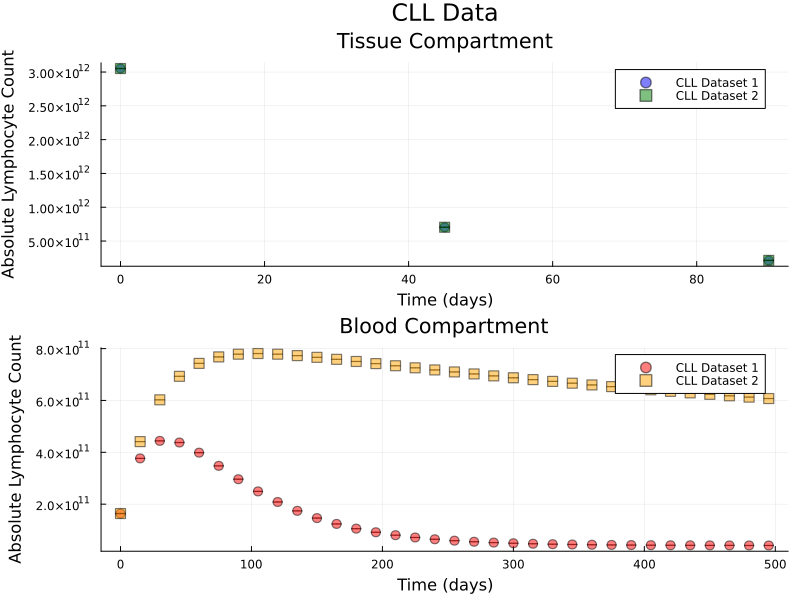

In [66]:
plot_cll(observed=[dataset1, dataset2], data_labels=["CLL Dataset 1", "CLL Dataset 2"], alpha=0.5)

In [94]:
# Starting values from the data
tissue_0 = dataset1["tissue"].values[1]
blood_0 = dataset1["blood"].values[1]

# Lower and upper bounds of the parameters
lb = [5e-5, 1e-4, 1e-4, 1e5] # Lower bound parameters
lb_0 = [0.75*tissue_0, 0.75*blood_0] # Lower bound initial conditions
ub = [0.5, 0.1, 0.1, tissue_0] # Upper bound parameters
ub_0 = [1.25*tissue_0, 1.25*blood_0] # Upper bound initial conditions

slow_model =  WodartzModel((m=0.015, d1=0.1, d2=0.002, c=5e10), (tissue=tissue_0, blood=blood_0));
fast_model =  WodartzModel((m=0.015, d1=0.1, d2=0.02, c=5e10), (tissue=tissue_0, blood=blood_0));

sol_slow = simulate(slow_model, tspan = (0.0, 500.0));
sol_fast = simulate(fast_model, tspan = (0.0, 500.0));


#### Plot both the fast and the slow model
The fast and slow models are created with the d2 to 0.02 and 0.002 respectively. The other parameters have been chosen such that the output is at least on the same scale as the provided data. (ofcourse once we estimate the parameters, we have a better result of what the parameters should be - but I briefly tuned them manually for now).

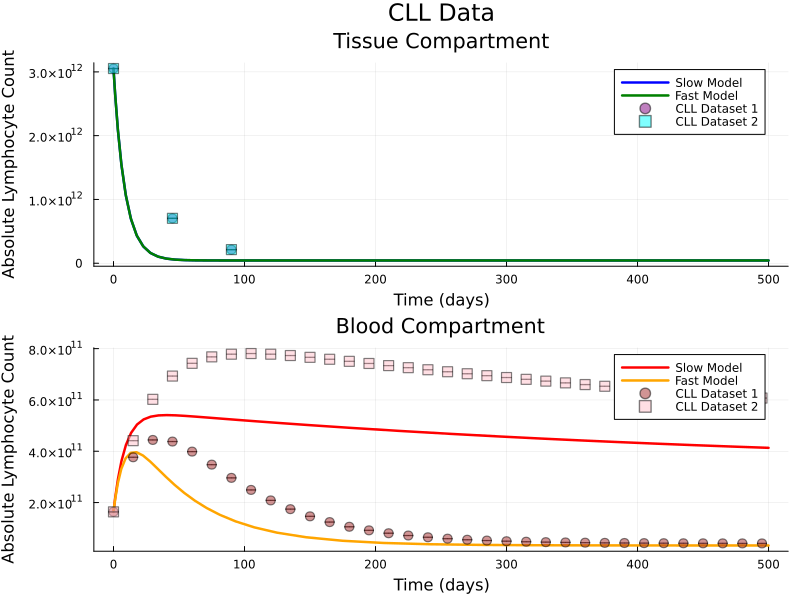

In [95]:
plot_cll(observed=[dataset1, dataset2], solutions=[sol_slow, sol_fast], data_labels=["CLL Dataset 1", "CLL Dataset 2"], solution_labels=["Slow Model", "Fast Model"], alpha=0.5)


### Derivation steady state values

The ODE system is given by:

$$\frac{dx}{dt} = -mx - d_1(x - c)$$
$$\frac{dy}{dt} = mx - d_2 y$$

At steady state -> both derivatives to 0.

**For the tissue compartment ($x_{ss}$):**

$$\frac{dx}{dt} = 0 \implies -mx - d_1(x - c) = 0 \implies x_{ss} = \frac{d_1 c}{m + d_1}$$

**For the blood compartment ($y_{ss}$):**

$$\frac{dy}{dt} = 0 \implies mx - d_2 y = 0 \implies y_{ss} = \frac{m x_{ss}}{d_2}$$

Substituting $x_{ss}$:
$$y_{ss} = \frac{m}{d_2} \cdot \frac{d_1 c}{m + d_1}$$


### Stability

To check stability, look at Jacobian at the steady state.

**Jacobian Matrix:**

$$J = \begin{bmatrix} \frac{\partial f_1}{\partial x} & \frac{\partial f_1}{\partial y} \\ \frac{\partial f_2}{\partial x} & \frac{\partial f_2}{\partial y} \end{bmatrix} = \begin{bmatrix} -(m + d_1) & 0 \\ m & -d_2 \end{bmatrix}$$

**Eigenvalues:**

The eigenvalues are then given by:
$$\lambda_1 = -(m + d_1)$$
$$\lambda_2 = -d_2$$

Both eigenvalues are **negative** (since $m$, $d_1$, and $d_2$ are all positive parameters). This means the steady state is **asymptotically stable**.

### Data Simulation 
(skipped)

### Parameter Inference
Assignment: implement & combine global search with local search.

**Alternatively : sample many starting points & optimize from best x.**

(I already had some functionality lying around for this - so I'll do this first). The ... does ...

In [104]:
using OptimizationOptimJL

# Initialize wodartz_model -> parameters will be estimated (so specific values here are of less importance (only matter for starting position if you don't sample a collection of starting points)).
wodartz_model = WodartzModel((m=0.015, d1=0.05, d2=0.002, c=1e10), (tissue=tissue_0, blood=blood_0));

# Create config struct for multistart of the fit_model method
# e.g. start with 10000 starting points (n_samples - sampled with latin hypercube sampling (method=:lhs)), pick 50 best ones (n_starts) to do local optimization from. 
# (NOTE: this is a bit overkill -> I already saw that both datasets give good convergence already from the 'guessed' starting points given above).
ms = MultiStartConfig(n_samples=10000, n_starts=50, method=:lhs, parallel=true, seed=42)

obs_data_vector1 = [dataset1["tissue"], dataset1["blood"]]
obs_data_vector2 = [dataset2["tissue"], dataset2["blood"]]

# Fit on 1st dataset
fitted_model1, result = fit_model(
    wodartz_model, obs_data_vector1, (:m, :d1, :d2, :c),
    lb=lb,
    ub=ub,
    optimizer=LBFGS(),
    maxiters=1000,
    multistart=ms
)
sol_fit1 = simulate(fitted_model1, tspan=(0.0, 500.0));

fitted_model2, result = fit_model(
    wodartz_model, obs_data_vector2, (:m, :d1, :d2, :c),
    lb=lb,
    ub=ub,
    optimizer=LBFGS(),
    maxiters=1000,
    multistart=ms
)

sol_fit2 = simulate(fitted_model2, tspan=(0.0, 500.0));


┌ Info: Optimizing from 50 best starts (losses: [1.3514893213818163e23, 1.63901911022746e23, 1.8911665304898884e23, 1.9511553882674364e23, 2.3075843988752184e23, 2.552382913670268e23, 2.6812702507858482e23, 2.692391860922806e23, 2.8338298698537528e23, 2.9052710362878513e23, 3.0027138356807826e23, 3.034558145214281e23, 3.1616748271277517e23, 3.236389940822666e23, 3.2412364377427633e23, 3.3352563652648724e23, 3.3559238108985565e23, 3.380670876325697e23, 3.428274359594805e23, 3.606583666117316e23, 3.746262833144722e23, 3.7536674095973415e23, 3.759312422281038e23, 3.814452058926698e23, 3.83544218364505e23, 3.962228235425463e23, 3.9996197297655276e23, 4.000513938923392e23, 4.00877538235499e23, 4.025781502457902e23, 4.0361241076362655e23, 4.046085564014905e23, 4.07843407275034e23, 4.193294092111013e23, 4.244774873241112e23, 4.359290070938289e23, 4.364817937134147e23, 4.381189635562467e23, 4.385418692174227e23, 4.393420655822976e23, 4.395370551769301e23, 4.49173655206517e23, 4.605349414997718

#### Plot fit results

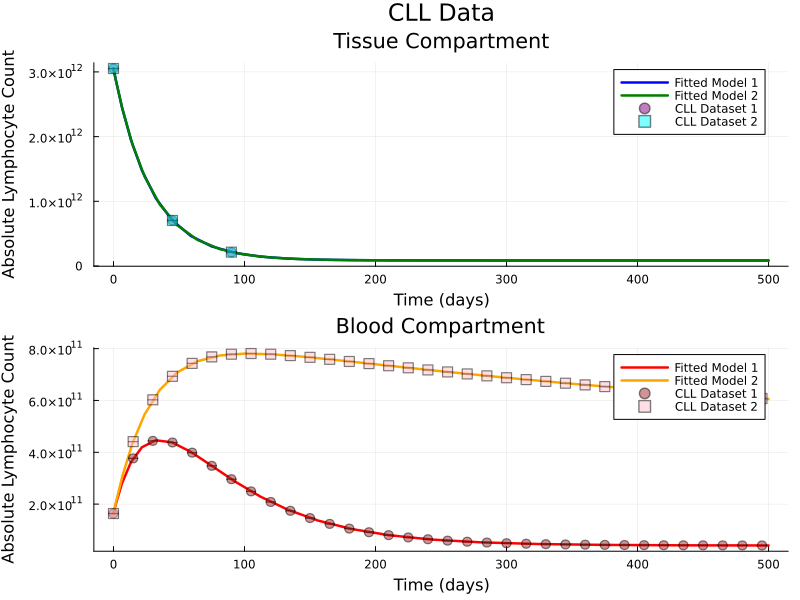

In [ ]:
plot_cll(observed=[dataset1, dataset2], solutions=[sol_fit1, sol_fit2], data_labels=["CLL Dataset 1", "CLL Dataset 2"], solution_labels=["Fitted Model 1", "Fitted Model 2"], alpha=0.5)

In [107]:
## Print fitted parameters
println("Fitted parameters for Dataset 1:")
for (param, value) in pairs(fitted_model1.parameters)
    println("$(param) = $(value)")
end

println("\nFitted parameters for Dataset 2:")
for (param, value) in pairs(fitted_model2.parameters)
    println("$(param) = $(value)")
end

Fitted parameters for Dataset 1:
m = 0.007959106365134893
d1 = 0.02693527614707485
d2 = 0.016954756435964433
c = 1.1099048438356435e11

Fitted parameters for Dataset 2:
m = 0.00796320679633891
d1 = 0.02687709684846524
d2 = 0.001693019706166935
c = 1.1079810314344142e11


#### Global + local search strategy

In [61]:
dataset1

Dict{String, ObservedData} with 2 entries:
  "tissue" => ObservedData([0.0, 45.0, 90.0], [3.0525e12, 7.0328e11, 2.129e11],…
  "blood"  => ObservedData([0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0, 120…

In [80]:
tissue_0

3.0525e12